## Natural Languange Process (NLP) II in Finance

This notebook provides an example of Topic Modeling in finance.

#### NLP Packages

* **NLTK** - Natural Language Toolkit for Python (see https://www.nltk.org)
* **spaCy** - Industrial-strength Natural Language Processing (see https://spacy.io)
* **Gensim** - Topic modeling and document similarity analysis (see https://radimrehurek.com/gensim/)
* **pyLDAvis** - Interactive topic model visualization (see https://pyldavis.readthedocs.io)

#### Visualization Packages

* **Matplotlib** - Comprehensive plotting library
* **Seaborn** - Statistical data visualization  
* **WordCloud** - Generate word cloud visualizations


In [1]:
import re
import pandas as pd

# NLP Toolkits
import nltk
import en_core_web_sm

2025-10-02 16:36:23.500199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

nlp = en_core_web_sm.load()

!pip install numpy==1.26.4
!pip install pandas==1.5.3

!pip install gensim

In [3]:
# Additional imports for enhanced visualizations and model evaluation
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")


!pip install wordcloud matplotlib seaborn


In [4]:
from gensim import corpora, models
from gensim.utils import simple_preprocess

#### Text Data

We'll upload:


**1. The Financial Phrase Bank** (Malo et al., 2014)
- **Description**: A collection of business and financial phrases manually annotated with sentiment scores
- **Size**: ~4,800 phrases with human-annotated sentiment labels
- **Labels**: Positive, Negative, Neutral
- **Use Case**: Benchmark dataset for evaluating sentiment analysis models
- **Download**: https://huggingface.co/datasets/financial_phrasebank/tree/main/data


In [5]:
df_phrases = pd.read_csv('Sentences_AllAgree.txt', delimiter='@', encoding='latin-1', on_bad_lines='skip', names=['Phrase', 'Sentiment'])
df_phrases.head()

,Phrase,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


### Text as Data

#### Text Preprocessing for Financial Data

Effective text preprocessing is crucial for financial NLP applications. The following function demonstrates a comprehensive preprocessing pipeline specifically designed for financial text:

**Preprocessing Steps:**

1. **Case Normalization**: Convert to lowercase for consistency
2. **Punctuation Removal**: Clean non-alphanumeric characters using regex
3. **Tokenization**: Split text into individual words using NLTK
4. **Stopword Removal**: Filter out common words that carry little meaning
5. **Lemmatization**: Reduce words to their base form using spaCy

In [6]:
def preprocess_text(text, stopwrds):
  filtered_tokens = []

  # Convert text to lowercase
  text = text.lower()

  # Remove punctuation and non-alphanumeric characters using regular expression
  text = re.sub(r'\W+', ' ', text)

  # Tokenize text using NLTK
  word_tokens = word_tokenize(text)

  # Remove stop words
  if stopwrds:
    filtered_tokens = [word for word in word_tokens if word not in stop_words]

    # Reconstruct the text without stop words
    text = ' '.join(filtered_tokens)

  # Use spaCy for lemmatization
  doc = nlp(text)
  lemmatized_text = " ".join([token.lemma_ for token in doc])

  return lemmatized_text

In [7]:
df_phrases['Pre_Processed'] = df_phrases['Phrase'].apply(lambda x: preprocess_text(x, True))
df_phrases['Pre_Processed_w_stopwords'] = df_phrases['Phrase'].apply(lambda x: preprocess_text(x, False))
df_phrases.head()

,Phrase,Sentiment,Pre_Processed,Pre_Processed_w_stopwords
0,"According to Gran , the company has no plans t...",neutral,accord gran company plan move production russi...,accord to gran the company have no plan to mov...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale double e...,for the last quarter of 2010 componenta s net ...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter 2010 net sale increase 5 2 eur 2...,in the third quarter of 2010 net sale increase...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,operating profit rise eur 13 1 mn eur 8 7 mn c...,operating profit rise to eur 13 1 mn from eur ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,operate profit total eur 21 1 mn eur 18 6 mn 2...,operate profit total eur 21 1 mn up from eur 1...


#### Bag of Words: Converting Text to Numbers

The Bag of Words (BoW) model is a fundamental technique for converting text data into numerical format that machine learning algorithms can process. This approach treats each document as a "bag" of words, ignoring word order but preserving frequency information.

In [8]:
texts = df_phrases['Pre_Processed'].apply(simple_preprocess)

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Convert dictionary to a Bag of Words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

#### Latent Dirichlet Allocation (LDA) Topic Modeling

**LDA Overview:**
Latent Dirichlet Allocation is a generative statistical model that discovers abstract topics in a collection of documents. In finance, LDA may help identify (based on the text corpus being analysed):

* **Market themes** - Economic trends, regulatory changes, sector-specific discussions
* **Risk factors** - Credit risk, operational risk, market volatility themes  
* **Investment strategies** - Growth vs. value, sector rotation, ESG considerations
* **Sentiment patterns** - Optimistic vs. pessimistic language clusters

**Model Parameters:**
* `num_topics=2` - We start with 2 topics to distinguish positive vs. negative sentiment themes
* `passes=20` - Number of training iterations through the corpus
* `random_state=42` - For reproducible results

In [9]:
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, passes=20, random_state=42)

# Print the topics
print("Topics discovered by LDA:")
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx}: {topic}')

Topics discovered by LDA:
Topic 0: 0.085*"eur" + 0.049*"mn" + 0.030*"profit" + 0.025*"sale" + 0.024*"net" + 0.020*"year" + 0.018*"quarter" + 0.018*"million" + 0.018*"mln" + 0.016*"period"
Topic 1: 0.012*"company" + 0.010*"share" + 0.009*"market" + 0.007*"finland" + 0.006*"say" + 0.006*"service" + 0.004*"price" + 0.004*"also" + 0.004*"percent" + 0.004*"business"


#### Model Evaluation: Topic Coherence

**Topic Coherence** measures how semantically similar the high-scoring words in a topic are to each other. Higher coherence scores indicate better topic quality.

**Coherence Measures:**
* **C_v**: Based on a sliding window and normalized pointwise mutual information (NPMI)
* **U_mass**: Based on document cooccurrence counts  
* **C_npmi**: Normalized pointwise mutual information
* **C_uci**: Based on pointwise mutual information (PMI)


In [10]:
# Calculate coherence scores
coherence_model_cv = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_model_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')

coherence_cv = coherence_model_cv.get_coherence()
coherence_umass = coherence_model_umass.get_coherence()

print(f"Coherence Score (C_v): {coherence_cv:.4f}")
print(f"Coherence Score (U_mass): {coherence_umass:.4f}")

# Interpretation
print("\nCoherence Score Interpretation:")
print("• C_v scores typically range from 0 to 1, with higher values indicating better topic coherence")
print("• U_mass scores are typically negative, with values closer to 0 indicating better coherence")
print("• For financial text analysis, C_v > 0.4 and U_mass > -3 generally indicate reasonable topic quality")


Coherence Score (C_v): 0.3983
Coherence Score (U_mass): -3.7622

Coherence Score Interpretation:
• C_v scores typically range from 0 to 1, with higher values indicating better topic coherence
• U_mass scores are typically negative, with values closer to 0 indicating better coherence
• For financial text analysis, C_v > 0.4 and U_mass > -3 generally indicate reasonable topic quality


### Topic Visualization

This section provides multiple visualization approaches to understand the discovered topics:

1. **Word Clouds** - Visual representation of the most important words in each topic
2. **Interactive LDA Visualization** - pyLDAvis for exploring topic-word and topic-document relationships
3. **Topic Distribution Analysis** - Understanding how topics are distributed across documents


#### Word Clouds for Each Topic

Word clouds provide an intuitive way to visualize the most important words in each topic, with word size proportional to importance.


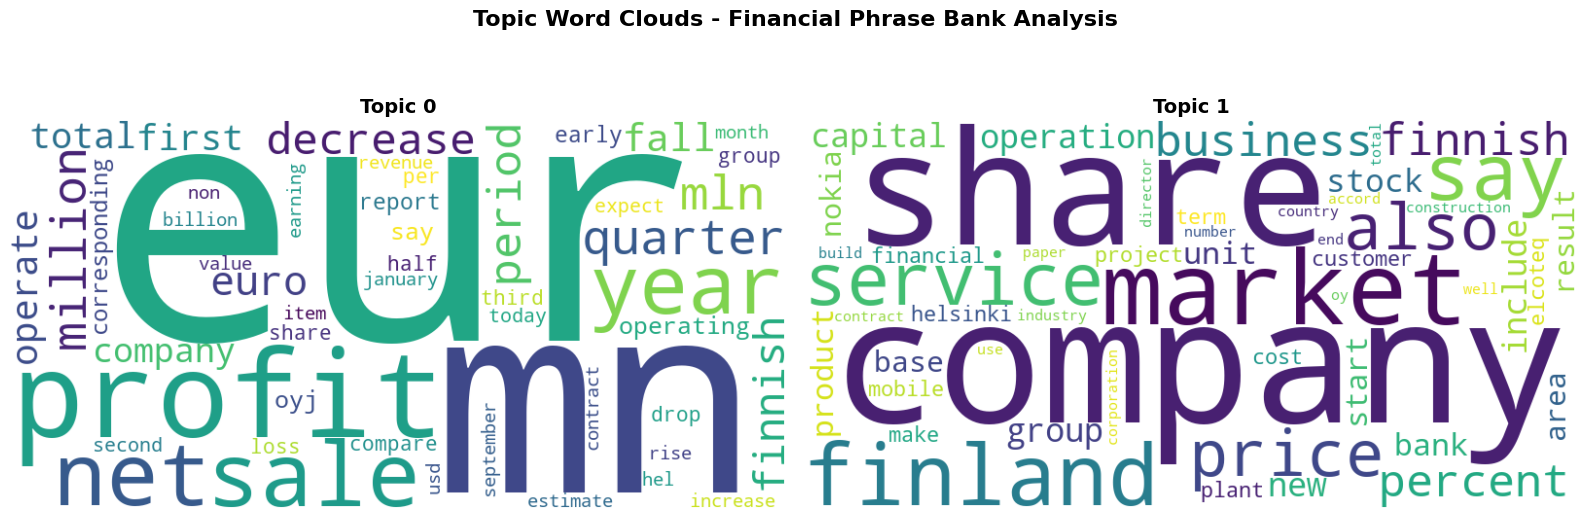


Top 10 words for each topic:

Topic 0:
  eur: 0.0854
  mn: 0.0492
  profit: 0.0296
  sale: 0.0251
  net: 0.0238
  year: 0.0205
  quarter: 0.0180
  million: 0.0180
  mln: 0.0175
  period: 0.0159

Topic 1:
  company: 0.0125
  share: 0.0102
  market: 0.0094
  finland: 0.0071
  say: 0.0062
  service: 0.0058
  price: 0.0045
  also: 0.0045
  percent: 0.0042
  business: 0.0041


In [11]:
# Generate word clouds for each topic
def create_topic_wordcloud(lda_model, topic_id, max_words=50):
    """Create a word cloud for a specific topic"""
    # Get topic words and their probabilities
    topic_words = dict(lda_model.show_topic(topic_id, max_words))
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(topic_words)
    
    return wordcloud

# Create subplots for word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Topic Word Clouds - Financial Phrase Bank Analysis', fontsize=16, fontweight='bold')

# Generate word clouds for each topic
for topic_id in range(lda_model.num_topics):
    wordcloud = create_topic_wordcloud(lda_model, topic_id)
    
    axes[topic_id].imshow(wordcloud, interpolation='bilinear')
    axes[topic_id].set_title(f'Topic {topic_id}', fontsize=14, fontweight='bold')
    axes[topic_id].axis('off')

plt.tight_layout()
plt.show()

# Print top words for each topic with probabilities
print("\nTop 10 words for each topic:")
for topic_id in range(lda_model.num_topics):
    print(f"\nTopic {topic_id}:")
    topic_words = lda_model.show_topic(topic_id, 10)
    for word, prob in topic_words:
        print(f"  {word}: {prob:.4f}")


#### Topic Distribution Analysis

Understanding how topics are distributed across documents and sentiment categories provides insights into the thematic structure of financial text.


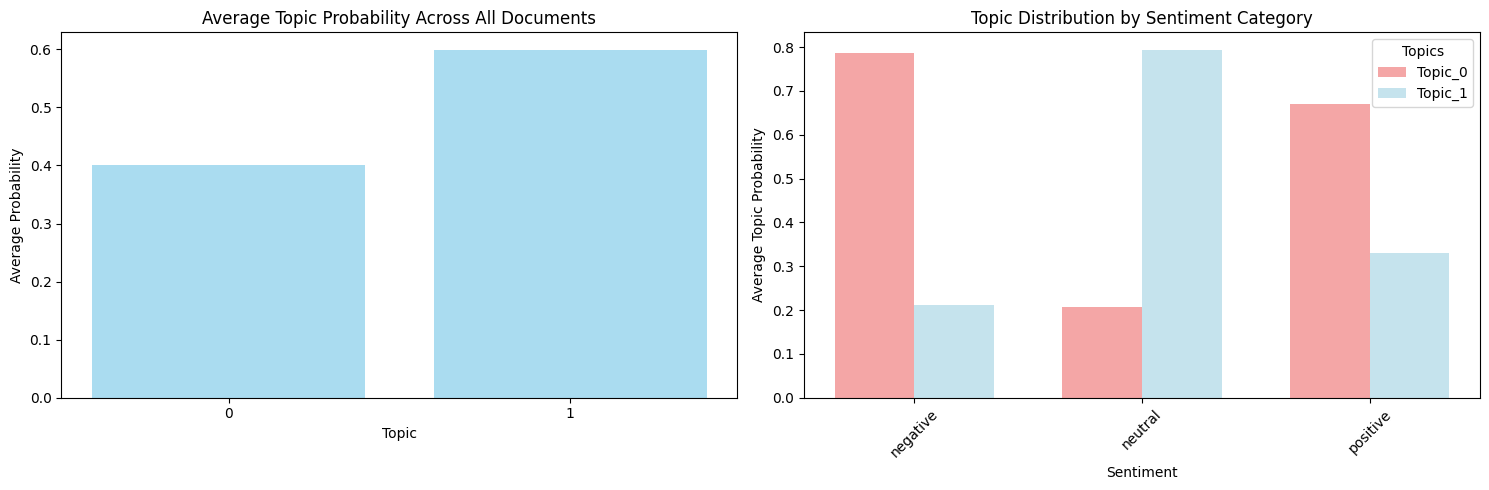

Topic Distribution Summary:
Total documents: 2264
Average topic probabilities:
  Topic 0: 0.4008
  Topic 1: 0.5992

Dominant topic distribution:
  Topic_1: 1433 documents (63.3%)
  Topic_0: 831 documents (36.7%)

Topic distribution by sentiment:
           Topic_0  Topic_1
Sentiment                  
negative    0.7876   0.2124
neutral     0.2060   0.7940
positive    0.6707   0.3293


In [12]:
# Get topic probabilities for each document
doc_topics = []
for doc_bow in corpus:
    topic_probs = lda_model.get_document_topics(doc_bow)
    # Convert to full probability vector
    topic_vec = [0.0] * lda_model.num_topics
    for topic_id, prob in topic_probs:
        topic_vec[topic_id] = prob
    doc_topics.append(topic_vec)

# Convert to DataFrame for analysis
topic_df = pd.DataFrame(doc_topics, columns=[f'Topic_{i}' for i in range(lda_model.num_topics)])
topic_df['Sentiment'] = df_phrases['Sentiment'].values

# Calculate dominant topic for each document
topic_df['Dominant_Topic'] = topic_df[[f'Topic_{i}' for i in range(lda_model.num_topics)]].idxmax(axis=1)

# Visualize topic distribution by sentiment
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Topic distribution across all documents
topic_means = topic_df[[f'Topic_{i}' for i in range(lda_model.num_topics)]].mean()
axes[0].bar(range(lda_model.num_topics), topic_means, color='skyblue', alpha=0.7)
axes[0].set_title('Average Topic Probability Across All Documents')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Average Probability')
axes[0].set_xticks(range(lda_model.num_topics))

# Topic distribution by sentiment - Fixed approach
sentiment_topic_dist = topic_df.groupby('Sentiment')[[f'Topic_{i}' for i in range(lda_model.num_topics)]].mean()

# Create the bar plot manually to avoid pandas plotting issues
x_pos = range(len(sentiment_topic_dist.index))
width = 0.35
colors = ['lightcoral', 'lightblue']

for i, topic_col in enumerate(sentiment_topic_dist.columns):
    axes[1].bar([x + width * i for x in x_pos], 
                sentiment_topic_dist[topic_col], 
                width, 
                label=topic_col, 
                color=colors[i % len(colors)],
                alpha=0.7)

axes[1].set_title('Topic Distribution by Sentiment Category')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Average Topic Probability')
axes[1].set_xticks([x + width/2 for x in x_pos])
axes[1].set_xticklabels(sentiment_topic_dist.index, rotation=45)
axes[1].legend(title='Topics')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Topic Distribution Summary:")
print(f"Total documents: {len(topic_df)}")
print(f"Average topic probabilities:")
for i in range(lda_model.num_topics):
    print(f"  Topic {i}: {topic_means.iloc[i]:.4f}")

print(f"\nDominant topic distribution:")
dominant_counts = topic_df['Dominant_Topic'].value_counts()
for topic, count in dominant_counts.items():
    print(f"  {topic}: {count} documents ({count/len(topic_df)*100:.1f}%)")

print(f"\nTopic distribution by sentiment:")
print(sentiment_topic_dist.round(4))


#### Enriching the Original Dataset with Topic Inferences

Before visualizing the topics, let's enhance our original dataframe with the topic model inferences. This creates a comprehensive dataset that combines the original phrases with their topic proportions and dominant topic assignments.


In [13]:
# Add topic proportions to the original dataframe
# We already calculated these in the topic distribution analysis, so we can reuse them

# Add topic proportion columns
for i in range(lda_model.num_topics):
    df_phrases[f'Topic_{i}_Proportion'] = topic_df[f'Topic_{i}'].values

# Add dominant topic information
df_phrases['Dominant_Topic'] = topic_df['Dominant_Topic'].values

# Add dominant topic probability (the highest probability among all topics for each document)
df_phrases['Dominant_Topic_Probability'] = topic_df[[f'Topic_{i}' for i in range(lda_model.num_topics)]].max(axis=1).values

# Create a more interpretable dominant topic label
topic_labels = {
    'Topic_0': 'Financial_Performance',  # Based on our analysis, this topic focuses on financial metrics
    'Topic_1': 'Business_Operations'     # This topic focuses on general business operations
}

df_phrases['Dominant_Topic_Label'] = df_phrases['Dominant_Topic'].map(topic_labels)

# Display the enhanced dataframe
print("Enhanced dataframe with topic inferences:")
print(f"Shape: {df_phrases.shape}")
print(f"New columns added: {[col for col in df_phrases.columns if 'Topic' in col or 'Dominant' in col]}")
print("\nFirst 5 rows with topic information:")
display_cols = ['Phrase', 'Sentiment', 'Topic_0_Proportion', 'Topic_1_Proportion', 
                'Dominant_Topic_Label', 'Dominant_Topic_Probability']
print(df_phrases[display_cols].head())

# Summary statistics of topic assignments
print(f"\nTopic Assignment Summary:")
print(f"Dominant Topic Distribution:")
topic_counts = df_phrases['Dominant_Topic_Label'].value_counts()
for topic, count in topic_counts.items():
    print(f"  {topic}: {count} phrases ({count/len(df_phrases)*100:.1f}%)")

print(f"\nAverage Topic Proportions:")
for i in range(lda_model.num_topics):
    avg_prop = df_phrases[f'Topic_{i}_Proportion'].mean()
    print(f"  Topic {i} ({topic_labels[f'Topic_{i}']}): {avg_prop:.4f}")

print(f"\nTopic Proportion Statistics:")
topic_prop_cols = [f'Topic_{i}_Proportion' for i in range(lda_model.num_topics)]
print(df_phrases[topic_prop_cols].describe().round(4))


Enhanced dataframe with topic inferences:
Shape: (2264, 9)
New columns added: ['Topic_0_Proportion', 'Topic_1_Proportion', 'Dominant_Topic', 'Dominant_Topic_Probability', 'Dominant_Topic_Label']

First 5 rows with topic information:
                                              Phrase Sentiment  \
0  According to Gran , the company has no plans t...   neutral   
1  For the last quarter of 2010 , Componenta 's n...  positive   
2  In the third quarter of 2010 , net sales incre...  positive   
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive   
4  Operating profit totalled EUR 21.1 mn , up fro...  positive   

   Topic_0_Proportion  Topic_1_Proportion   Dominant_Topic_Label  \
0            0.060800            0.939200    Business_Operations   
1            0.974819            0.025181  Financial_Performance   
2            0.957838            0.042162  Financial_Performance   
3            0.961297            0.038703  Financial_Performance   
4            0.953934         

#### Interactive Topic Visualization with pyLDAvis

Now that we have enriched our dataset with topic inferences, let's create an interactive visualization to explore the topic model in detail.

pyLDAvis provides an interactive web-based visualization that helps interpret the topics in an LDA model. The visualization includes:

* **Left panel**: Topics as circles, where circle size represents topic prevalence
* **Right panel**: Top terms for the selected topic, with bars showing term frequency within the topic and across the corpus
* **Interactive features**: Click on topics to explore their top terms, adjust the λ parameter to balance term frequency vs. exclusivity

**Using the Enhanced Dataset**: The topic proportions we just added to `df_phrases` can now be used for:
- Filtering phrases by topic confidence
- Analyzing sentiment patterns within specific topics  
- Creating topic-based investment strategies
- Building supervised models using topic features


!pip install pyLDAvis

In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [15]:
pyLDAvis.enable_notebook()
prepared_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Visualizing
pyLDAvis.display(prepared_vis)